**다층 퍼셉트론 구조가 좋을 줄 알았으나 MLPClassifier처럼 기본 코드가 우수하였음**

**다양하게 알고리즘 접근이 필요하다고 느낌**

# 1등 코드공유

- MFCC Feature + MLP 모델 성능이 좋았고 Unlabeled된 데이터를 활용해서 Semi-supervised Learning을 진행함

## Semi-supervised Learning이란?

- 준지도학습(semi-supervised learning, SSL)
- 지도학습 (supervised learning, SL)와 비지도학습(unsupervised learning, UL)
    - 학습 데이터의 라벨 유무를 통해 나뉨

### 지도학습

- 정답이 되는 데이터(labeled data)를 학습시켜 데이터가 무엇인지 예측
- 분류 (classification), 회귀 (regression) 으로 나뉨

### 비지도학습

- 정답지 없이 주어진 입력 데이터 간의 숨어있는 구조를 찾아 비슷한 데이터끼리 묶는 것을 목표

### 준지도학습

- 레이블링된 데이터와 레이블링되지 않는 데이터가 모두 사용
- 한 쪽의 데이터에 있는 추가 정보를 활용해 다른 데이터 학습에서의 성능을 높이는 것을 목표로 함

## 준지도학습

- 레이블되지 않은 데이터가 의미 있게 사용되기 위해서는 데이터 분포에 대한 몇 가지 과정이 필요
1. smoothness 가정

2. low-density 가정

3. manifold 가정

---
**1등 코드를 보면 unlabel을 train data와 합쳐서 사용하였음**


# 코드

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import os
import random
from scipy import signal
from collections import defaultdict
from tqdm import tqdm
import IPython
from collections import Counter

from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, scale, LabelEncoder, StandardScaler, MinMaxScaler, Normalizer, minmax_scale
from sklearn.metrics import log_loss, f1_score, roc_curve, accuracy_score, roc_auc_score, precision_recall_curve, plot_roc_curve, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn import linear_model
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import svm

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, BatchNormalization, Flatten, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

#from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Trim, Gain, PolarityInversion, SpecCompose, SpecChannelShuffle, SpecFrequencyMask

from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading

import warnings
warnings.filterwarnings(action='ignore')

C:\Users\hansol\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
train_df = pd.read_csv('./data/train_data.csv')
test_df = pd.read_csv('./data/test_data.csv')
unlabeled_df = pd.read_csv('./data/unlabeled_data.csv')

In [3]:
train_df.head()

,id,age,gender,respiratory_condition,fever_or_muscle_pain,covid19
0,1,24,female,0,1,0
1,2,51,male,0,0,0
2,3,22,male,0,0,0
3,4,29,female,1,0,0
4,5,23,male,0,0,0


In [4]:
train_df.shape

(3805, 6)

In [5]:
test_df.head()

,id,age,gender,respiratory_condition,fever_or_muscle_pain
0,3806,48,female,1,0
1,3807,24,female,0,0
2,3808,29,male,0,0
3,3809,39,female,0,0
4,3810,34,male,0,0


In [6]:
test_df.shape

(5732, 5)

In [7]:
unlabeled_df.head()

,id,age,gender,respiratory_condition,fever_or_muscle_pain
0,9538,35,male,1,0
1,9539,40,female,0,1
2,9540,33,male,0,0
3,9541,35,male,0,0
4,9542,54,female,0,0


In [8]:
unlabeled_df.shape

(1867, 5)

In [9]:
CFG = {
    'SR' : 16000,
    'N_MFCC' : 15,
    'SEED' : 41,
    'N_MELS' : 128
}

In [10]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

In [11]:
seed = CFG['SEED']

- 녹음 파일 형태 분석

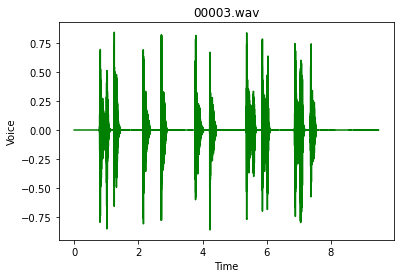

In [12]:
wav_path = './data/train/00003.wav'
(file_dir, file_id) = os.path.split(wav_path)
y,sr = librosa.load(wav_path, sr = CFG['SR'])

time = np.linspace(0, len(y)/sr, len(y))
fig, ax = plt.subplots()
ax.plot(time, y, color = 'g')
ax.set_xlabel('Time')
ax.set_ylabel('Voice')
plt.title(file_id)
plt.show()

In [13]:
IPython.display.Audio(data=y,rate=sr)

In [14]:
def get_pre_features(df, wav, save_path):
    zip_path = './data'
    
    if os.path.exists(save_path):
        return print(f'{save_path} is exist.')
    
    hop_length = CFG['SR'] * 0.01
    n_fft = CFG['SR'] * 0.025
    win_length = n_fft

    y_mean_mfcc = []
    
    for uid in tqdm(df.id):
        train_path = os.path.join(zip_path, wav)
        wav_path = os.path.join(train_path, str(uid).zfill(5) + '.wav')
        
        y, sr = librosa.load(wav_path, sr = CFG['SR'])
        
        mels = librosa.feature.melspectrogram(y, sr = sr, n_mels = CFG['N_MELS'])
        
        S = np.abs(mels)
        
        log_S = librosa.power_to_db(S, ref = np.max)
        
        mfcc = librosa.feature.mfcc(y = y, S = log_S, sr = sr, n_mfcc = CFG['N_MFCC'], n_fft = n_fft, win_length = win_length, hop_length = hop_length)
        
        x_mean_mfcc = []
        for item in mfcc:
            x_mean_mfcc.append(np.mean(item))
        y_mean_mfcc.append(x_mean_mfcc)

    mfcc_mean_df = pd.DataFrame(y_mean_mfcc, columns = ['mfcc_mean'+str(x) for x in range(1, CFG['N_MFCC']+1)])
    df = pd.concat([df, mfcc_mean_df], axis = 1)
    
    df.to_csv(save_path, index = False)
    
    return df

In [16]:
train_pre_df = get_pre_features(train_df, 'train', './train_mfcc_df.csv')

100%|██████████████████████████████████████████████████████████████████████████████| 3805/3805 [18:33<00:00,  3.42it/s]


In [17]:
test_pre_df = get_pre_features(test_df, 'test', './test_mfcc_df.csv')

100%|██████████████████████████████████████████████████████████████████████████████| 5732/5732 [27:21<00:00,  3.49it/s]


In [18]:
unlabeled_pre_df = get_pre_features(unlabeled_df, 'unlabeled', './unlabeled_mfcc_df.csv')

100%|██████████████████████████████████████████████████████████████████████████████| 1867/1867 [10:01<00:00,  3.10it/s]


- mfcc 추출하여 평균을 냄

In [19]:
train_pre_df.head()

,id,age,gender,respiratory_condition,fever_or_muscle_pain,covid19,mfcc_mean1,mfcc_mean2,mfcc_mean3,mfcc_mean4,...,mfcc_mean6,mfcc_mean7,mfcc_mean8,mfcc_mean9,mfcc_mean10,mfcc_mean11,mfcc_mean12,mfcc_mean13,mfcc_mean14,mfcc_mean15
0,1,24,female,0,1,0,-688.948792,29.345425,-19.152718,-7.836882,...,-8.553542,-32.653942,-12.341259,-5.151809,2.669801,-7.865372,10.570987,2.887321,4.517178,-8.187103
1,2,51,male,0,0,0,-644.907776,52.478149,-0.098957,-11.070889,...,-1.739854,-15.766101,-1.017933,-3.985816,7.574249,-10.625892,3.174112,-10.302366,1.404506,-10.507941
2,3,22,male,0,0,0,-763.585571,46.588909,-22.689060,-3.607528,...,0.270997,-9.013165,-9.624514,-7.756682,2.647656,-7.490925,1.030777,-1.478194,-3.565254,-3.868448
3,4,29,female,1,0,0,-722.977417,46.939358,-7.443123,-3.694383,...,-9.271688,-10.894087,-11.857489,2.555442,-2.403031,-17.141569,4.961744,-8.069848,0.244983,-3.172915
4,5,23,male,0,0,0,-813.072205,7.165524,-7.422007,2.231186,...,-0.644982,-6.101686,-0.874724,0.401199,0.912838,-5.177626,-1.340888,-3.866655,-1.082266,-2.545630


In [20]:
test_pre_df.head()

,id,age,gender,respiratory_condition,fever_or_muscle_pain,mfcc_mean1,mfcc_mean2,mfcc_mean3,mfcc_mean4,mfcc_mean5,mfcc_mean6,mfcc_mean7,mfcc_mean8,mfcc_mean9,mfcc_mean10,mfcc_mean11,mfcc_mean12,mfcc_mean13,mfcc_mean14,mfcc_mean15
0,3806,48,female,1,0,-876.085388,9.328650,0.821095,2.373343,-0.171163,-1.189314,-3.113831,-0.829437,-2.221059,0.153570,-1.919320,0.480115,-1.152479,-0.310618,0.101920
1,3807,24,female,0,0,-841.897461,8.492652,-2.758263,-2.801816,-2.770231,1.993531,-5.280821,-0.315033,0.839241,0.299542,-1.058011,3.300240,-2.794021,-0.276257,-0.596889
2,3808,29,male,0,0,-149.131256,-2.354820,-7.397019,-0.686011,-5.422640,1.605195,-8.221066,-1.894476,-5.367864,-1.281690,-4.855124,-3.338654,-9.028275,-2.546837,-2.562082
3,3809,39,female,0,0,-790.577271,27.119740,-9.231675,9.747519,-1.013352,-4.020472,-13.982764,-11.758769,0.593286,-0.994719,-13.632190,0.128249,-3.824995,-5.212523,-5.973090
4,3810,34,male,0,0,-751.237122,45.165871,-14.454832,-2.965205,-9.931789,10.073366,-0.863068,-6.342820,-6.891338,-9.549931,-6.007560,1.517536,-5.699742,3.236500,-4.142823


In [21]:
train_pre_df_copy = train_pre_df.copy()
test_pre_df_copy = test_pre_df.copy()
unlabeled_pre_df_copy = unlabeled_pre_df.copy()

In [22]:
train_pre_df_copy.shape, test_pre_df_copy.shape, unlabeled_pre_df_copy.shape

((3805, 21), (5732, 20), (1867, 20))

In [23]:
def onehot_encoder_(encoder, x, col_list):
    for col in col_list:
        encoder = encoder
        encoder.fit(x[col].values.reshape(-1, 1))
        encoded = encoder.transform(x[col].values.reshape(-1, 1))
        encoded_df = pd.DataFrame(encoded, columns = encoder.categories_[0])
        x = pd.concat([x.drop(columns = [col]), encoded_df], axis = 1)
    return x

def label_encoder_(encoder, x, col_list):
    for col in col_list:
        encoder = encoder
        encoder.fit(x[col].values.reshape(-1, 1))
        x[col] = encoder.transform(x[col].values.reshape(-1, 1))
    return x

- 성별을 인코딩함

In [24]:
col_list = ['gender']
encoder = OneHotEncoder(sparse = False)
train_pre_df_copy = onehot_encoder_(encoder, train_pre_df_copy, col_list)
test_pre_df_copy = onehot_encoder_(encoder, test_pre_df_copy, col_list)
unlabeled_pre_df_copy = onehot_encoder_(encoder, unlabeled_pre_df_copy, col_list)

In [25]:
train_pre_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3805 entries, 0 to 3804
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3805 non-null   int64  
 1   age                    3805 non-null   int64  
 2   respiratory_condition  3805 non-null   int64  
 3   fever_or_muscle_pain   3805 non-null   int64  
 4   covid19                3805 non-null   int64  
 5   mfcc_mean1             3805 non-null   float32
 6   mfcc_mean2             3805 non-null   float32
 7   mfcc_mean3             3805 non-null   float32
 8   mfcc_mean4             3805 non-null   float32
 9   mfcc_mean5             3805 non-null   float32
 10  mfcc_mean6             3805 non-null   float32
 11  mfcc_mean7             3805 non-null   float32
 12  mfcc_mean8             3805 non-null   float32
 13  mfcc_mean9             3805 non-null   float32
 14  mfcc_mean10            3805 non-null   float32
 15  mfcc

In [26]:
train_x = train_pre_df_copy.drop(columns=['id', 'covid19'])
train_y = train_pre_df_copy['covid19']

In [27]:
test_x = test_pre_df_copy[train_x.columns]
unlabeled_x = unlabeled_pre_df_copy[train_x.columns]

- 사이킷런에서 제공하는 다층퍼셉트론 분류를 통해 모델 학습

In [28]:
model = MLPClassifier(activation = 'relu', solver = 'adam', random_state=seed)
model.fit(train_x, train_y)
prob = model.predict_proba(unlabeled_x)
semiprediction = np.where(prob < 0.487, 1, 0)

In [29]:
unlabeled_x['covid19'] = -1
unlabeled_x['covid19'] = semiprediction

In [30]:
unlabeled_x.covid19.value_counts()

0    1566
1     301
Name: covid19, dtype: int64

In [31]:
unlabeled_y = unlabeled_x['covid19']
unlabeled_x = unlabeled_x.drop(['covid19'], axis = 1)

In [32]:
all_x = pd.concat([train_x, unlabeled_x], axis=0)
all_y = pd.concat([train_y, unlabeled_y], axis=0)

In [33]:
model = MLPClassifier(activation = 'relu', solver = 'adam', random_state=seed)
model.fit(all_x, all_y)
prob = model.predict_proba(test_x)
prediction = np.where(prob < 0.663, 1, 0)

In [36]:
submission = pd.read_csv('./data/sample_submission.csv')
submission['covid19'] = prediction
submission.to_csv('./submission.csv', index=False)

In [37]:
submission.covid19.value_counts()

0    5293
1     439
Name: covid19, dtype: int64

In [ ]:
submission